c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\takat\AppData\Local\Temp\ipykernel_18240\1426904555.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], palette="deep")


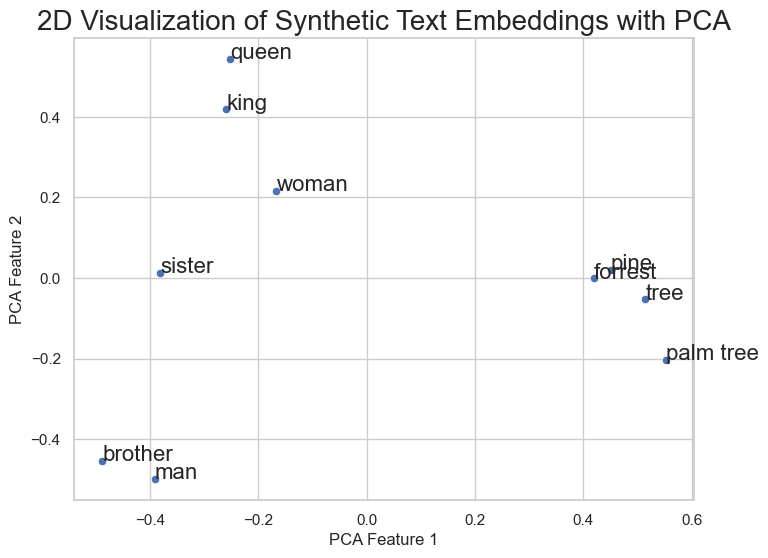

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA


# List of texts to embed
# Redefining the list of texts
texts = ["man", "woman", "queen", "king", "tree", "forrest", "palm tree", "pine","sister", "brother"]

# Creating synthetic embeddings
# np.random.seed(42)  # Fixing the random seed for reproducibility
# embeddings = np.random.rand(len(texts), 10)  # 10-dimensional embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embedding the texts
embeddings = model.encode(texts)

# Using PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)
# Visualizing the embeddings using the viridis color scheme
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], palette="deep")
for i, text in enumerate(texts):
    plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], text, fontsize=16)
plt.title("2D Visualization of Synthetic Text Embeddings with PCA", fontsize=20)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
# sns.set(style="whitegrid")
plt.show()

In [24]:
embeddings.shape

(10, 384)

In [39]:
import pandas as pd

# Creating 10 bad reviews
bad_reviews = [
    "Absolutely terrible. The plot was predictable and the acting was wooden.",
    "Waste of time. The special effects were laughable and the story made no sense.",
    "Very disappointing. The characters were one-dimensional and not at all likable.",
    "A total letdown. The pacing was slow and it failed to hold my attention.",
    "Not recommended. The script was full of cliches and lacked originality.",
    "Boring and uneventful. The movie dragged on with no real purpose.",
    "Poorly made. The editing was choppy and the sound quality was bad.",
    "Not worth watching. The dialogue was cheesy and the humor fell flat.",
    "A big disappointment. The film lacked depth and the ending was unsatisfying.",
    "Terrible execution. The direction was poor and the cinematography was unimpressive.",
    "Dull and uninspiring. The storyline was unoriginal and the ending was predictable.",
    "Failed to impress. The performances were mediocre and the direction lacked vision.",
    "Forgettable and tedious. The film had no real suspense or engaging elements.",
    "A real snooze-fest. The script was uninspired and the characters were forgettable.",
    "Missed the mark. The film tried too hard to be deep but ended up being pretentious.",
    "Lackluster and unconvincing. The plot twists were predictable and uninteresting.",
    "Unappealing and draggy. The movie seemed to go on forever without any real point.",
    "Disjointed and confusing. The narrative was hard to follow and lacked coherence.",
    "Underwhelming in every aspect. The cinematography was bland and the soundtrack forgettable.",
    "A waste of potential. The movie had a good premise but failed in execution.",
]

# Creating 10 good reviews
good_reviews = [
    "Absolutely fantastic. The plot was original and the acting was superb.",
    "A must-see. The special effects were stunning and the story was captivating.",
    "Highly recommended. The characters were complex and very relatable.",
    "A masterpiece. The pacing was perfect and it kept me engaged throughout.",
    "Brilliantly written. The script was fresh and full of creativity.",
    "Engaging and entertaining. The movie flowed smoothly and had a strong message.",
    "Well-crafted. The editing was seamless and the sound quality was top-notch.",
    "Thoroughly enjoyable. The dialogue was witty and the humor was spot on.",
    "A true gem. The film had depth and the ending was very satisfying.",
    "Outstanding direction. The cinematography was stunning and visually impressive.",
    "Riveting and captivating. The story was engaging with plenty of unexpected twists.",
    "A visual masterpiece. The cinematography and special effects were breathtaking.",
    "Brilliantly acted. The cast delivered powerful and memorable performances.",
    "A refreshing take on the genre. The film brought new ideas and executed them perfectly.",
    "Heartfelt and moving. The story resonated emotionally and stayed with me long after.",
    "Excellently paced. The film kept the excitement up from start to finish.",
    "A work of art. The direction was innovative and the script was clever and insightful.",
    "Engrossing and thought-provoking. The film challenges the audience in the best way.",
    "A triumph of storytelling. The narrative was intricate yet perfectly balanced.",
    "A delightful surprise. The movie exceeded expectations with its charm and wit.",
]

# Combining reviews with labels
reviews = bad_reviews + good_reviews
labels = ['Bad'] * 20 + ['Good'] * 20

# Creating a DataFrame
df = pd.DataFrame({'Review': reviews, 'Label': labels})
df.head(20)


,Review,Label
0,Absolutely terrible. The plot was predictable ...,Bad
1,Waste of time. The special effects were laugha...,Bad
2,Very disappointing. The characters were one-di...,Bad
3,A total letdown. The pacing was slow and it fa...,Bad
4,Not recommended. The script was full of cliche...,Bad
5,Boring and uneventful. The movie dragged on wi...,Bad
6,Poorly made. The editing was choppy and the so...,Bad
7,Not worth watching. The dialogue was cheesy an...,Bad
8,A big disappointment. The film lacked depth an...,Bad
9,Terrible execution. The direction was poor and...,Bad


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

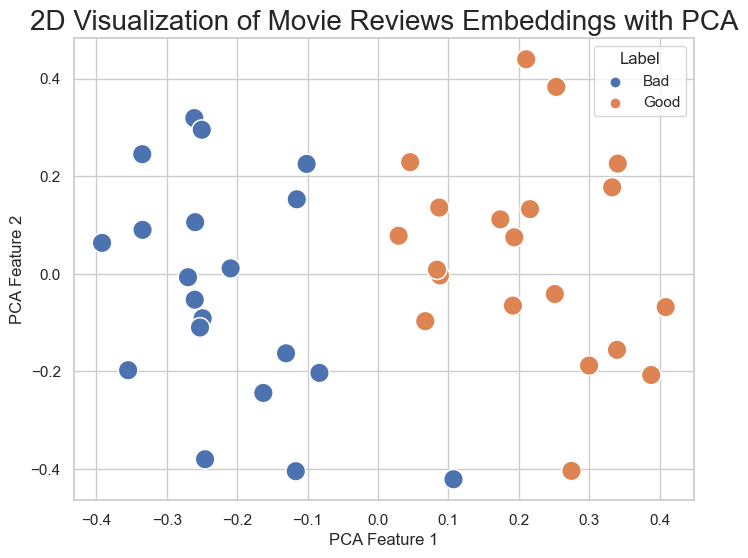

In [40]:
embeddings = model.encode(df['Review'].tolist())

# Using PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

# Visualizing the embeddings using the viridis color scheme
plt.figure(figsize=(8, 6))

# Color coding: green for good reviews, red for bad reviews
colors = ['green' if label == 'Good' else 'red' for label in df['Label']]

# Scatter plot with color coding
sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], hue=df['Label'],s=200)

# Adding texts
# for i, text in enumerate(df['Review']):
#     plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], text, fontsize=9)

plt.title("2D Visualization of Movie Reviews Embeddings with PCA", fontsize=20)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\takat\AppData\Local\Temp\ipykernel_6616\1030301358.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assig

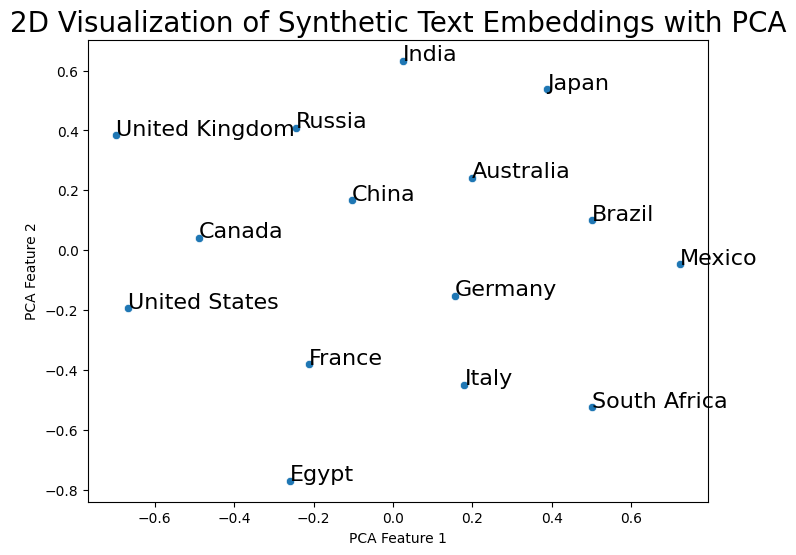

In [65]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA


# List of texts to embed
# Redefining the list of texts
texts = [
    "United States", "Canada", "Mexico", "Brazil", "United Kingdom",
    "Germany", "France", "Italy", "Russia", "China", "Japan", "India",
    "Australia", "South Africa", "Egypt",
]

# Creating synthetic embeddings
# np.random.seed(42)  # Fixing the random seed for reproducibility
# embeddings = np.random.rand(len(texts), 10)  # 10-dimensional embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embedding the texts
embeddings = model.encode(texts)

from sklearn.manifold import MDS

# Create an MDS instance specifying the number of dimensions (n_components=2 for 2D)
mds = MDS(n_components=2)

# Apply MDS to the embeddings
embeddings_2d_pca = mds.fit_transform(embeddings)

# embeddings_2d_mds now contains the 2-dimensional representation of your embeddings

# Visualizing the embeddings using the viridis color scheme
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], palette="deep")
for i, text in enumerate(texts):
    plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], text, fontsize=16)
plt.title("2D Visualization of Synthetic Text Embeddings with PCA", fontsize=20)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
# sns.set(style="whitegrid")
plt.show()

In [77]:
# Re-defining the texts and lat_lng_data as they were not recognized in the previous code cell

texts = [
    "United States", "Brazil", "United Kingdom",
    "Germany", "Italy",  "China", "Japan", 
    "Australia", "South Africa", "Egypt",
]
# Defining neighbors for each country
neighbors = {
    "United States": "Canada",
    "Brazil": "Argentina",
    "United Kingdom": "Ireland",
    "Germany": "France",
    "Italy": "Switzerland",
    "China": "India",
    "Japan": "South Korea",
    "Australia": "New Zealand",
    "South Africa": "Zimbabwe",
    "Egypt": "Libya"
}

# Creating a new list with one neighbor for each country
one_neighbor_list = [neighbors[country] for country in texts]
one_neighbor_list



['Canada',
 'Argentina',
 'Ireland',
 'France',
 'Switzerland',
 'India',
 'South Korea',
 'New Zealand',
 'Zimbabwe',
 'Libya']

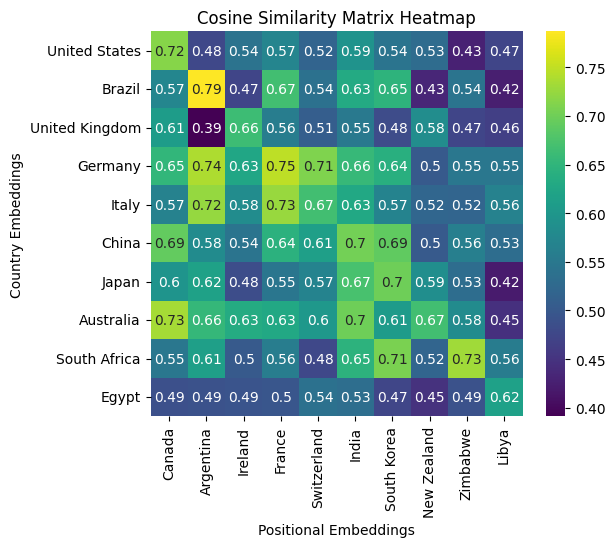

In [82]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
embeddings_countries = model.encode(texts)
embeddings_pos = model.encode(one_neighbor_list)
cosine_sim_matrix = cosine_similarity(embeddings_countries, embeddings_pos)

# Plotting the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cosine_sim_matrix, annot=True, cmap='viridis', 
            xticklabels=one_neighbor_list, yticklabels=texts)
plt.title("Cosine Similarity Matrix Heatmap")
plt.xlabel("Positional Embeddings")
plt.ylabel("Country Embeddings")
plt.show()

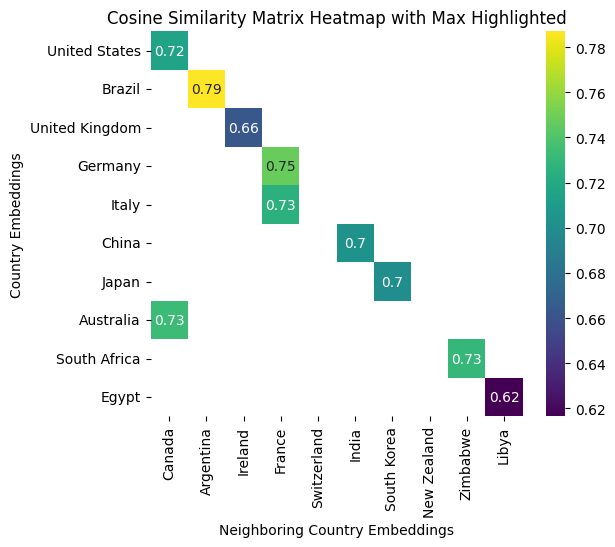

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a mask for the maximum value in each row
max_mask = np.zeros_like(cosine_sim_matrix, dtype=bool)
for i in range(len(cosine_sim_matrix)):
    max_mask[i, np.argmax(cosine_sim_matrix[i])] = True

# Plotting the heatmap with proper labels and the maximum values highlighted
plt.figure(figsize=(6, 5))
sns.heatmap(cosine_sim_matrix, mask=~max_mask, annot=True, cmap='viridis', 
            xticklabels=one_neighbor_list, yticklabels=texts)
plt.title("Cosine Similarity Matrix Heatmap with Max Highlighted")
plt.xlabel("Neighboring Country Embeddings")
plt.ylabel("Country Embeddings")
plt.show()